## Predicting credit default risk to reduce financial losses

### Business problem
Banks and financial institutions incur losses when customers fail to meet their credit obligations.  
This project aims to predict whether a credit card client will default in the following month.
Early identification of high-risk borrowers enables lenders to reduce expected losses, improve risk-based pricing, and intervene proactively.

### Stakeholders
**Primary stakeholders**
- Credit risk and risk analytics teams in banks and financial institutions  

**Secondary stakeholders**
- Product managers responsible for pricing and credit limits  
- Collections teams prioritising outreach  
- Senior management monitoring portfolio risk 

### Project objective
* Develop and evaluate classification models that estimate the probability of default using borrower demographics and credit behaviour data.  
* Model performance is assessed using evaluation metrics that prioritise correctly identifying defaulters.

### Dataset
The dataset used is the UCI Credit Card Default dataset, which contains 30,000 observations of credit card clients. It includes demographic information, credit limits, historical billing amounts, repayment behaviour over six months, and whether the customer defaulted in the following month.

#### Variables

##### 1. Target Variable

- `default.payment.next.month`
  - 1 = Default  
  - 0 = No default  

This is a binary classification problem.

##### 2. Features (Independent Variables)
All borrower and credit-related variables are used as predictors, excluding `ID`:

- Credit limit: `LIMIT_BAL`
- Demographics: `AGE`, `EDUCATION`, `SEX`, `MARRIAGE`
- Repayment history: `PAY_0` to `PAY_6`
- Monthly bill amounts: `BILL_AMT1` to `BILL_AMT6`
- Monthly payment amounts: `PAY_AMT1` to `PAY_AMT6`

## Load libraries and data

In [494]:
!pip install -q kagglehub


In [495]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# Download dataset from Kaggle / UCI
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

# print("Path to dataset files:", path)
os.listdir(path)

df = pd.read_csv(os.path.join(path, "UCI_Credit_Card.csv"))
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [496]:
# Size and structure of data
df.shape

(30000, 25)

In [497]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [498]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [499]:
"""
The dataset contains no missing values or duplicate values. All variables are numeric, which simplifies preprocessing
"""

'\nThe dataset contains no missing values or duplicate values. All variables are numeric, which simplifies preprocessing\n'

## Exploratory Data Analysis (EDA)

### 1. Distribution of borrower's default  status

In [500]:
# Count observations in each class --how many defaults vs non-defaults
df['default.payment.next.month'].value_counts()


0    23364
1     6636
Name: default.payment.next.month, dtype: int64

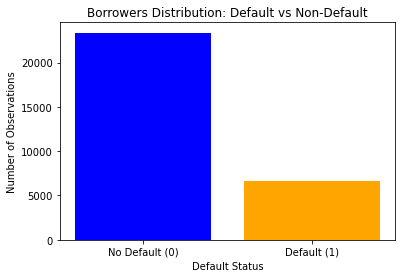

In [501]:
# Get value counts for default vs non-default
class_counts = df['default.payment.next.month'].value_counts()

# Plot bar chart
plt.figure(figsize=(6,4))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['blue', 'orange'])
plt.title("Borrowers Distribution: Default vs Non-Default")
plt.xlabel('Default Status')
plt.ylabel('Number of Observations')
plt.xticks([0, 1], ['No Default (0)', 'Default (1)'])
plt.show()

In [502]:
"""
The dataset contains approximately 30,000 observations and 25 variables, including the target variable.  
The target variable is binary, with about 22% of borrowers defaulting in the following month and 78% not defaulting.
Def:
1=default
0=no default
This indicates a moderately imbalanced dataset, making accuracy a potentially misleading evaluation metric. Therefore, this project will  prioritize evaluation metrics such as recall for the default class and ROC-AUC to better capture the model’s ability to identify high-risk borrowers.
"""

'\nThe dataset contains approximately 30,000 observations and 25 variables, including the target variable.  \nThe target variable is binary, with about 22% of borrowers defaulting in the following month and 78% not defaulting.\nDef:\n1=default\n0=no default\nThis indicates a moderately imbalanced dataset, making accuracy a potentially misleading evaluation metric. Therefore, this project will  prioritize evaluation metrics such as recall for the default class and ROC-AUC to better capture the model’s ability to identify high-risk borrowers.\n'

### 2. Default rate by repayment status (PAY_0, PAY_2, PAY_3)

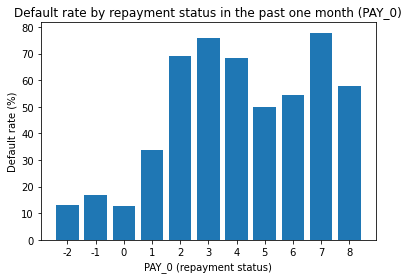

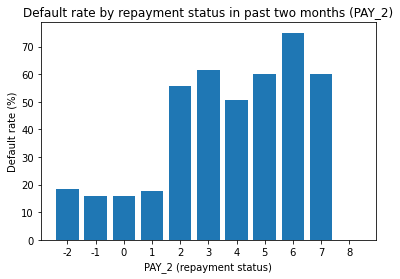

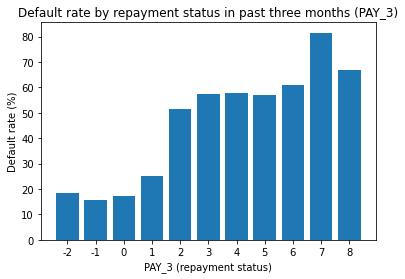

In [503]:
def plot_default_rate_by_pay_status(df, pay_col, target_col='default.payment.next.month', title=None):
    # Compute default rate by category
    rate = (df.groupby(pay_col)[target_col]
              .mean()
              .sort_index()) * 100

    plt.figure()
    plt.bar(rate.index.astype(str), rate.values)
    plt.title(title or f"Default rate by {pay_col}")
    plt.xlabel(f"{pay_col} (repayment status)")
    plt.ylabel("Default rate (%)")
    plt.xticks(rotation=0)
    plt.show()

# Plots
plot_default_rate_by_pay_status(df, 'PAY_0', title="Default rate by repayment status in the past one month (PAY_0)")
plot_default_rate_by_pay_status(df, 'PAY_2', title="Default rate by repayment status in past two months (PAY_2)")
plot_default_rate_by_pay_status(df, 'PAY_3', title="Default rate by repayment status in past three months (PAY_3)")

In [504]:
### Results of repayment behavior and default risk
"""
Repayment status variables (PAY_0, PAY_2, and PAY_3) show a clear pattern: default rates rise significantly as payment delays become more severe. Borrowers with no current delays have low default rates, while those with recent delays face much higher risk.
The effect is strongest for PAY_0, indicating that recent payment delays (delinquency) is a powerful early warning signal of future default and highlighting the importance of repayment history in predicting credit risk
"""

'\nRepayment status variables (PAY_0, PAY_2, and PAY_3) show a clear pattern: default rates rise significantly as payment delays become more severe. Borrowers with no current delays have low default rates, while those with recent delays face much higher risk.\nThe effect is strongest for PAY_0, indicating that recent payment delays (delinquency) is a powerful early warning signal of future default and highlighting the importance of repayment history in predicting credit risk\n'

### 3. Default rate by credit limit (LIMIT_BAL)

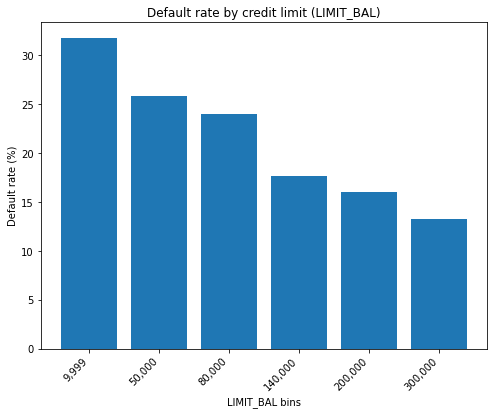

In [505]:
plot_default_rate_by_binned_numeric(
    df,
    num_col='LIMIT_BAL',
    bins=6,
    strategy='quantile',
    title="Default rate by credit limit (LIMIT_BAL)"
)

In [506]:
### Results of credit limit and default risk
"""
The chart shows a clear inverse relationship between credit limit and default risk. Borrowers with lower credit limits have noticeably higher default rates, while those with higher limits demonstrate progressively lower default risk.
This suggests that credit capacity is a meaningful indicator of financial stability. Customers with stronger credit profiles and higher limits are less likely to default.
"""

'\nThe chart shows a clear inverse relationship between credit limit and default risk. Borrowers with lower credit limits have noticeably higher default rates, while those with higher limits demonstrate progressively lower default risk.\nThis suggests that credit capacity is a meaningful indicator of financial stability. Customers with stronger credit profiles and higher limits are less likely to default.\n'

### 4. Default rate by recent payment amount (PAY_AMT1)

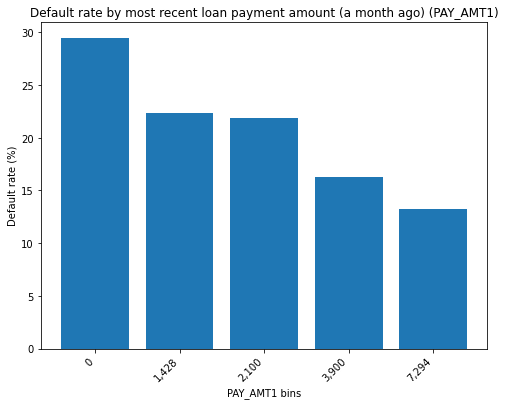

In [507]:
plot_default_rate_by_binned_numeric(
    df,
    num_col='PAY_AMT1',
    bins=6,
    strategy='quantile',
    title="Default rate by most recent loan payment amount (a month ago) (PAY_AMT1)"
)

In [508]:
###  Results of default rate by recent payment amount (PAY_AMT1)
"""
Default risk decreases as recent payment amounts increase. Borrowers making smaller payments exhibit higher default rates, while those making larger payments show progressively lower risk.
This reinforces that repayment capacity is an important indicator of credit stability.
"""

'\nDefault risk decreases as recent payment amounts increase. Borrowers making smaller payments exhibit higher default rates, while those making larger payments show progressively lower risk.\nThis reinforces that repayment capacity is an important indicator of credit stability.\n'

### 5. Default rate by recent outstanding bill/debts ('BILL_AMT1')

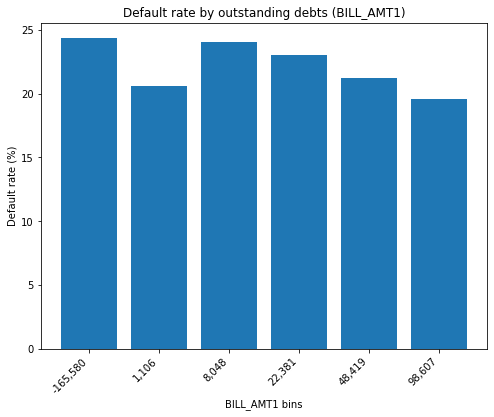

In [509]:
plot_default_rate_by_binned_numeric(
    df,
    num_col='BILL_AMT1',
    bins=6,
    strategy='quantile',
    title="Default rate by outstanding debts (BILL_AMT1)"
)

In [510]:
###  Results of default rate by recent outstanding bill/debts (BILL_AMT1)
"""
The chart shows no clear relationship between outstanding bill amounts and default risk. Default rates do not consistently increase as the bill amount grows, indicating that the size of the debt alone is not a strong predictor of default
"""

'\nThe chart shows no clear relationship between outstanding bill amounts and default risk. Default rates do not consistently increase as the bill amount grows, indicating that the size of the debt alone is not a strong predictor of default\n'

### 6. Default rate by age of the borrower ('AGE')

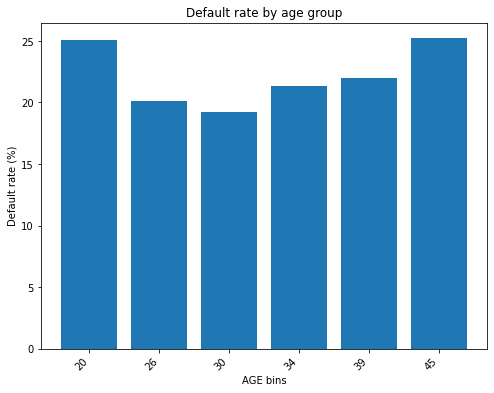

In [511]:
# Default rate by AGE (binned)
plot_default_rate_by_binned_numeric(
    df,
    num_col='AGE',
    bins=6,
    strategy='quantile',
    title="Default rate by age group"
)

In [512]:
###  Results of default rate by age of the borrower (AGE)
"""
The age distribution for defaulters and non-defaulters is broadly similar. There is no significant pattern indicating that age alone is a strong predictor of default risk. The differences in default rates are relatively small compared to other features like repayment behavior and credit capacity.
"""

'\nThe age distribution for defaulters and non-defaulters is broadly similar. There is no significant pattern indicating that age alone is a strong predictor of default risk. The differences in default rates are relatively small compared to other features like repayment behavior and credit capacity.\n'

### 7. Default rate by gender of the borrower ('SEX')

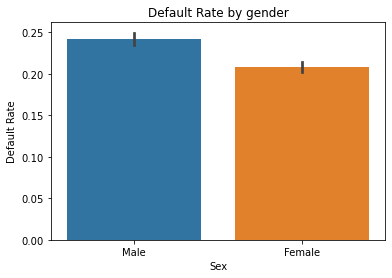

In [513]:
# Default rate by GENDER
sns.barplot(
    x='SEX',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by gender')
plt.xlabel('Sex')
plt.ylabel('Default Rate')
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

In [514]:
###  Results of default rate by gender of the borrower (SEX)
"""
The default rates for male and female borrowers are relatively similar, with only a small difference between the two groups. This suggests that gender is not a strong predictor of default risk in this dataset. The slight variation observed is likely due to other factors, such as repayment behavior or credit capacity, rather than gender itself.
"""

'\nThe default rates for male and female borrowers are relatively similar, with only a small difference between the two groups. This suggests that gender is not a strong predictor of default risk in this dataset. The slight variation observed is likely due to other factors, such as repayment behavior or credit capacity, rather than gender itself.\n'

### 8. Default rate by education of the borrower ('EDUCATION')

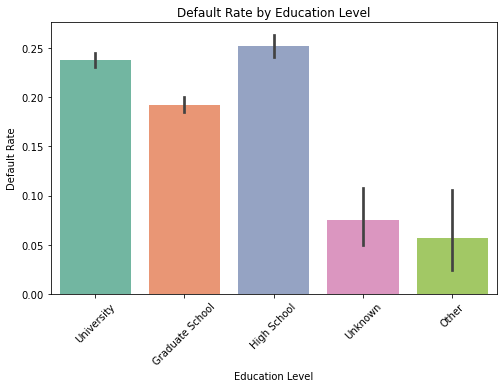

In [515]:
# Clean education categories
education_labels = {
    1: "Graduate School",
    2: "University",
    3: "High School",
    4: "Other",
    0: "Unknown",
    5: "Unknown",
    6: "Unknown"
}

df['EDUCATION_LABEL'] = df['EDUCATION'].map(education_labels)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(
    x='EDUCATION_LABEL',
    y='default.payment.next.month',
    data=df,
    palette="Set2"
)

plt.title("Default Rate by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Default Rate")
plt.xticks(rotation=45)
plt.show()

In [516]:
###  Results of default rate by education of the borrower (EDUCATION)
"""
There is no clear trend showing that one education level is strongly associated with a higher or lower risk of default. This suggests that factors beyond education, such as repayment behavior and credit capacity, are stronger predictors of default risk.
"""

'\nThere is no clear trend showing that one education level is strongly associated with a higher or lower risk of default. This suggests that factors beyond education, such as repayment behavior and credit capacity, are stronger predictors of default risk.\n'

### 9. Default rate by marriage status of the borrower ('MARRIAGE')

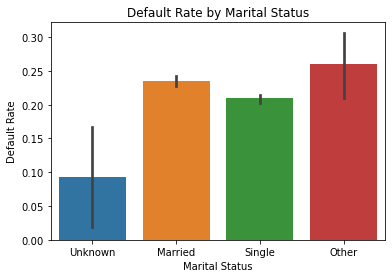

In [517]:
sns.barplot(
    x='MARRIAGE',
    y='default.payment.next.month',
    data=df
)

plt.title('Default Rate by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Default Rate')
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=['Unknown', 'Married', 'Single', 'Other']
)
plt.show()

In [518]:
###  Results of default rate by marriage status of the borrower (MARRIAGE)
"""
Default rates vary slightly across marital status categories, but the differences are not substantial. There is no strong pattern indicating that marital status alone is a key driver of default risk.
Overall, behavioral variables such as repayment history and payment amounts remain more influential predictors of default.
"""

'\nDefault rates vary slightly across marital status categories, but the differences are not substantial. There is no strong pattern indicating that marital status alone is a key driver of default risk.\nOverall, behavioral variables such as repayment history and payment amounts remain more influential predictors of default.\n'

### 10. Multicollinearity test

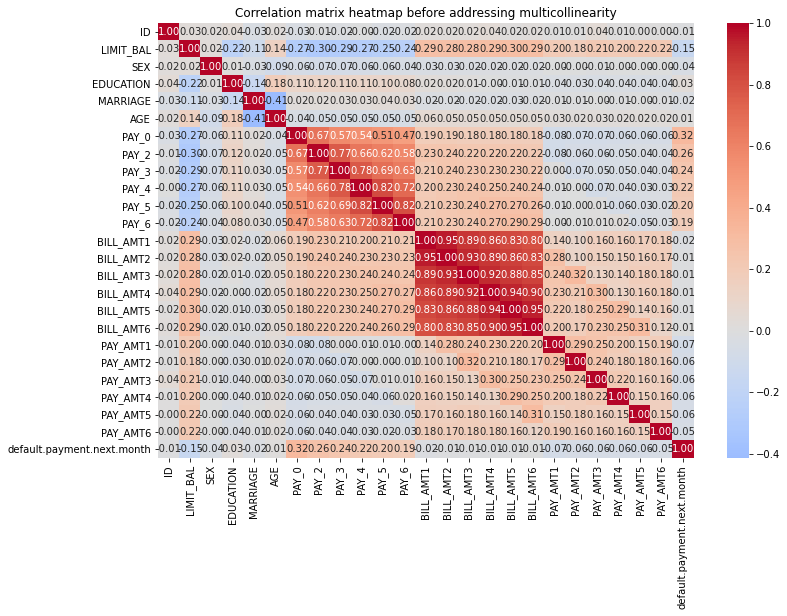

In [519]:
# Compute correlation matrix
corr = df.corr()

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title('Correlation matrix heatmap before addressing multicollinearity')
plt.show()


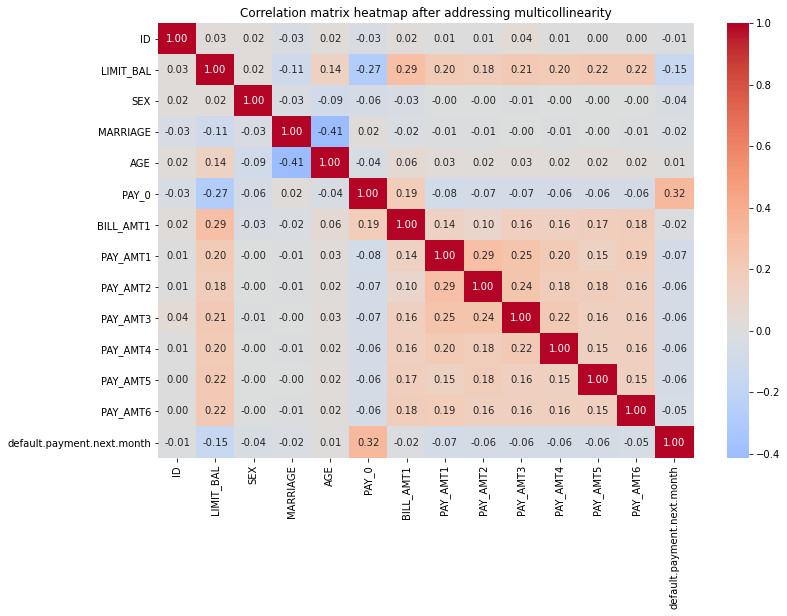

In [520]:
# Drop only the highly correlated columns that are redundant
df_cleaned = df.drop(columns=['PAY_3','PAY_2', 'PAY_4', 'PAY_5','PAY_6','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','EDUCATION', 'EDUCATION_LABEL'])

# Re-run the correlation matrix after cleaning
corr = df_cleaned.corr()

# Generate the heatmap again
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title('Correlation matrix heatmap after addressing multicollinearity')
plt.show()

In [543]:
df_cleaned.shape

(30000, 14)

#### Wrap up of the EDA 

- Repayment delays show a strong and consistent relationship with default risk.
- Default rates increase significantly as recent payment delays become more severe.
- Lower credit limits are associated with higher default rates.
- Smaller recent payment amounts correspond to higher default risk.
- Demographic factors (age, gender, education, marital status) show limited variation in default risk.

Overall, repayment behavior and credit capacity emerge as the strongest indicators of default risk.


## Model development

### 1. Logistic regression model -baseline

We first define the target variable and independent variables 
* The target variable shows whether a borrower defaults in the following month. 
* The independent set includes borrower demographics, credit capacity, repayment history, and billing information etc
* Identifier variables that do not contain predictive information are removed.


In [544]:
# Define target variable and independent variables
# Define target variable
y = df_cleaned['default.payment.next.month']
X = df_cleaned.drop(columns=['ID', 'default.payment.next.month'])

In [523]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   BILL_AMT1                   30000 non-null  float64
 7   PAY_AMT1                    30000 non-null  float64
 8   PAY_AMT2                    30000 non-null  float64
 9   PAY_AMT3                    30000 non-null  float64
 10  PAY_AMT4                    30000 non-null  float64
 11  PAY_AMT5                    30000 non-null  float64
 12  PAY_AMT6                    30000 non-null  float64
 13  default.payment.next.month  300

In [545]:
X.shape, y.shape
# This confirms that the predictors matrix (X) contains 23 independent variables and the target vector (y) contains the binary default outcome for all 30,000 observations.

((30000, 12), (30000,))

In [525]:
# Train test split
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,    # reproducibility
    stratify=y          # keeps same default rate in train and test
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 12), (6000, 12), (24000,), (6000,))

##### Independent variabes scaling
* The dataset contains features on different scales (i.e., credit limits, bills, repayment status), so standardization is necessary.

* Without scaling, variables with larger values can disproportionately influence the logistic regression model.

* Standardizing ensures features are on a similar scale, allowing the model to learn more fairly and improving training stability.

In [526]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data ONLY
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test_scaled = scaler.transform(X_test)

X_train_scaled

"""
The scaler is fitted only on the training data to prevent data leakage. 
The test data is transformed using the same parameters learned from the training set.
"""

'\nThe scaler is fitted only on the training data to prevent data leakage. \nThe test data is transformed using the same parameters learned from the training set.\n'

In [527]:
# build the logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Logistic Regression
log_reg = LogisticRegression(random_state=42)

# Train the model on the scaled training data
log_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8108333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.70      0.25      0.37      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.61      0.63      6000
weighted avg       0.79      0.81      0.77      6000

Confusion Matrix:
 [[4533  140]
 [ 995  332]]


In [528]:
### Logistic regression baseline results
"""
The logistic regression model achieved 81% accuracy, but due to class imbalance, accuracy is misleading.
While it identifies non-defaulters well (97% recall), it captures only 25% of defaulters, missing 995 out of 1,327.
These false negatives are costly because high-risk customers are classified as safe. Therefore, the analysis prioritizes maximizing defaulter recall while maintaining reasonable precision.
"""

'\nThe logistic regression model achieved 81% accuracy, but due to class imbalance, accuracy is misleading.\nWhile it identifies non-defaulters well (97% recall), it captures only 25% of defaulters, missing 995 out of 1,327.\nThese false negatives are costly because high-risk customers are classified as safe. Therefore, the analysis prioritizes maximizing defaulter recall while maintaining reasonable precision.\n'

### 2. Logistic regression with class weights

* The baseline model had very low recall for defaulters (25%), meaning most high-risk borrowers were missed.
* Since identifying defaulters is the primary objective, improving recall is critical.
* Before moving to a more complex model such as a decision tree, we addressed class imbalance within logistic regression by adjusting class weights.
* This penalizes misclassification of defaulters more heavily, allowing us to test whether handling imbalance alone improves recall before adding model complexity.

In [529]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression with class weights to handle imbalance
log_reg_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

log_reg_balanced.fit(X_train_scaled, y_train)

y_pred_balanced = log_reg_balanced.predict(X_test_scaled)

print("Logistic Regression (class_weight='balanced') Results:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))

Logistic Regression (class_weight='balanced') Results:
Confusion Matrix:
 [[3219 1454]
 [ 496  831]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.69      0.77      4673
           1       0.36      0.63      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.61      6000
weighted avg       0.76      0.68      0.70      6000



In [530]:
# The balanced logistic regression results
"""
The balanced logistic regression significantly improves recall for defaulters from 25% to 63%. The model now correctly identifies 831 out of 1,327 defaulters, reducing missed defaulters from 995 in the baseline model to 496 ie cutting false negatives nearly in half compared to the baseline model.
Although overall accuracy decreases from 81% to 76%, this trade-off is expected when prioritizing the minority class. From a business perspective, reducing false negatives is critical because each missed defaulter represents potential financial loss.
"""

'\nThe balanced logistic regression significantly improves recall for defaulters from 25% to 63%. The model now correctly identifies 831 out of 1,327 defaulters, reducing missed defaulters from 995 in the baseline model to 496 ie cutting false negatives nearly in half compared to the baseline model.\nAlthough overall accuracy decreases from 81% to 76%, this trade-off is expected when prioritizing the minority class. From a business perspective, reducing false negatives is critical because each missed defaulter represents potential financial loss.\n'

#### Feature importance of the balanced logistic regression

The coefficients indicate which variables increase or decrease the likelihood of default. Positive coefficients increase default risk, while negative coefficients reduce it.


In [531]:
# Create dataframe of coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg_balanced.coef_[0]
})

# Sort by absolute importance
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10 most important features
coef_df[['Feature', 'Coefficient']].head(10)

,Feature,Coefficient
4,PAY_0,0.698643
0,LIMIT_BAL,-0.169873
6,PAY_AMT1,-0.153317
7,PAY_AMT2,-0.148244
5,BILL_AMT1,-0.092945
1,SEX,-0.067890
2,MARRIAGE,-0.064072
3,AGE,0.059359
9,PAY_AMT4,-0.034684
8,PAY_AMT3,-0.030568


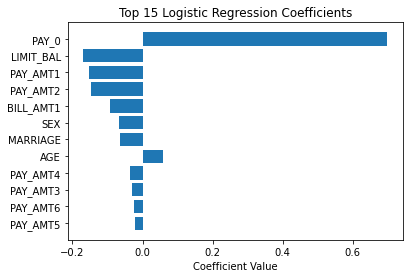

In [532]:
# Display top 10 most important features
coef_df[['Feature', 'Coefficient']].head(10)

import matplotlib.pyplot as plt

top_features = coef_df[['Feature', 'Coefficient']].head(15)

plt.figure()
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.gca().invert_yaxis()
plt.title("Top 15 Logistic Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.show()

In [533]:
# # The features importance results
"""
The most influential predictor of default is recent repayment status (PAY_0), which reflects whether a borrower has recently delayed payments. Higher values indicate more severe payment delays, strongly increasing default risk.
In contrast, higher recent payment amounts (PAY_AMT1, PAY_AMT2) and higher credit limits (LIMIT_BAL) are associated with lower default risk. This suggests that borrowers who maintain stronger repayment behavior and have greater credit capacity are less likely to default.

Overall, the model confirms that;
1. Recent repayment behavior is the strongest driver of default risk
2. Higher credit limit reduced default risk (negative coefficient)
"""

'\nThe most influential predictor of default is recent repayment status (PAY_0), which reflects whether a borrower has recently delayed payments. Higher values indicate more severe payment delays, strongly increasing default risk.\nIn contrast, higher recent payment amounts (PAY_AMT1, PAY_AMT2) and higher credit limits (LIMIT_BAL) are associated with lower default risk. This suggests that borrowers who maintain stronger repayment behavior and have greater credit capacity are less likely to default.\n\nOverall, the model confirms that;\n1. Recent repayment behavior is the strongest driver of default risk\n2. Higher credit limit reduced default risk (negative coefficient)\n'

### 3. Building the decision tree model

After improving logistic regression by addressing class imbalance, we next evaluate a Decision Tree model. Unlike logistic regression, which assumes a linear relationship between features and the target, Decision Trees can capture nonlinear patterns and complex feature interactions.

This allows us to assess whether a more flexible, nonparametric model can further improve recall for defaulters.

In [534]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Train model
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Accuracy: 0.7278333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82      4673
           1       0.39      0.40      0.39      1327

    accuracy                           0.73      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.73      0.73      0.73      6000


Confusion Matrix:
 [[3835  838]
 [ 795  532]]


In [535]:
## Decision Tree Results
"""
The Decision Tree model achieved an overall accuracy of 72.7%. Recall for defaulters improved to 40%, compared to 25% in the baseline logistic regression. This reduces missed defaulters from 995 to 795.
However, when compared to the balanced logistic regression model (63% recall), the default Decision Tree does not perform as well at identifying high-risk borrowers.
Although the tree is capable of capturing nonlinear relationships, it does not yet outperform logistic regression when class imbalance is properly addressed. Therefore, we next retrain the Decision Tree using class weights to determine whether imbalance handling can further improve recall.
"""

'\nThe Decision Tree model achieved an overall accuracy of 72.7%. Recall for defaulters improved to 40%, compared to 25% in the baseline logistic regression. This reduces missed defaulters from 995 to 795.\nHowever, when compared to the balanced logistic regression model (63% recall), the default Decision Tree does not perform as well at identifying high-risk borrowers.\nAlthough the tree is capable of capturing nonlinear relationships, it does not yet outperform logistic regression when class imbalance is properly addressed. Therefore, we next retrain the Decision Tree using class weights to determine whether imbalance handling can further improve recall.\n'

### 4. Decision tree with class weights
* The decision tree model improved recall as compared to the baseline model but did not outperform the balanced logistic regression. 
* Given the impact of class imbalance, we retrained it using class_weight='balanced' to penalize misclassifying defaulters and assess whether this improves recall.


In [536]:
# Decision Tree with class weight balancing
dt_balanced = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced'
)

# Train model
dt_balanced.fit(X_train, y_train)

# Predictions
y_pred_dt_balanced = dt_balanced.predict(X_test)

# Evaluation
print("Decision Tree (class_weight='balanced') Results")
print("Accuracy:", accuracy_score(y_test, y_pred_dt_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt_balanced))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt_balanced))

Decision Tree (class_weight='balanced') Results
Accuracy: 0.7346666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83      4673
           1       0.40      0.41      0.40      1327

    accuracy                           0.73      6000
   macro avg       0.62      0.62      0.62      6000
weighted avg       0.74      0.73      0.74      6000


Confusion Matrix:
 [[3870  803]
 [ 789  538]]


In [537]:
"""
The balanced Decision Tree achieved an accuracy of 73%. However, recall for defaulters stood at 41%, identifying only 538 out of 1,327 defaulters and missing 789 high-risk borrowers.
When compared to the balanced logistic regression model (63% recall), the Decision Tree performs substantially worse at detecting defaulters. Although the tree captures nonlinear relationships, increasing model complexity did not improve minority class detection in this case.
These results suggest that addressing class imbalance has a greater impact on recall than switching to a more flexible model.
"""

'\nThe balanced Decision Tree achieved an accuracy of 73%. However, recall for defaulters stood at 41%, identifying only 538 out of 1,327 defaulters and missing 789 high-risk borrowers.\nWhen compared to the balanced logistic regression model (63% recall), the Decision Tree performs substantially worse at detecting defaulters. Although the tree captures nonlinear relationships, increasing model complexity did not improve minority class detection in this case.\nThese results suggest that addressing class imbalance has a greater impact on recall than switching to a more flexible model.\n'

## Final model selection
Two evaluation approaches were used:
1. Recall: Prioritized for detecting defaulters. The balanced logistic regression had the highest recall (63%).
2. ROC–AUC: Measures model’s ability to separate defaulters. Balanced logistic regression had the highest AUC (0.710)


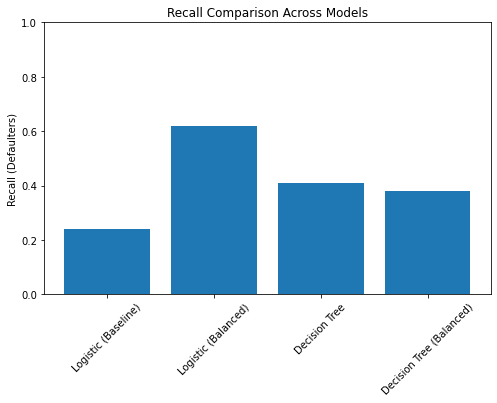

In [540]:
## 1. Chart of recalls (defaulters) from the four models

"""
The balanced logistic regression significantly improved detection of defaulters (62% recall way higher than others).
Because the business objective is to minimise missed high-risk borrowers, the balanced logistic regression is selected as the final model.
"""

models = [
    "Logistic (Baseline)",
    "Logistic (Balanced)",
    "Decision Tree",
    "Decision Tree (Balanced)"
]

recalls = [0.24, 0.62, 0.41, 0.38]

plt.figure(figsize=(8,5))
plt.bar(models, recalls)
plt.title("Recall Comparison Across Models")
plt.ylabel("Recall (Defaulters)")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

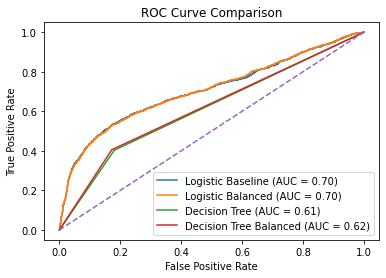

In [539]:
## 2. ROC AUC curve
"""
The ROC curve evaluates how well each model distinguishes between defaulters and non-defaulters.
Both logistic regression models achieved the highest AUC (0.71), outperforming the decision tree models (0.60–0.61). This indicates stronger overall predictive performance.
"""
from sklearn.metrics import roc_curve, roc_auc_score

models = {
    "Logistic Baseline": log_reg,
    "Logistic Balanced": log_reg_balanced,
    "Decision Tree": dt,
    "Decision Tree Balanced": dt_balanced
}

plt.figure()

for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled if "Logistic" in name else X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

Therefore, based on both recall and AUC, the balanced logistic regression is selected as the final model. Its performance is as shown below:
* Recall (Defaulters): 63%
* Precision (Defaulters): 36%
* Accuracy: 76%
* AUC: 0.70%

## Limitations

* Higher recall comes at the cost of lower precision, meaning some low-risk borrowers may be flagged for review.
* The model is based on historical data and requires ongoing monitoring to remain reliable.

## Conclusions
1. Recent repayment behavior is the strongest driver of default risk.
2. Higher credit limit reduces default risk (negative coefficient).
3. Recent payment delays are a strong indicator of future default, highlighting the need for early intervention strategies for at-risk customers.
4. Credit limit adjustments should be dynamic, rewarding good repayment behavior and minimizing exposure to high-risk borrowers.


## Business recommendations

Based on these findings, the bank/financial institutions should:

- Closely monitor customers with recent missed or delayed payments, as they exhibit significantly higher default risk.
- Implement early intervention strategies such as reminder notifications or repayment support for at-risk customers.
-  Carefully review credit limits, recognizing that customers with stronger credit profiles and higher limits tend to demonstrate lower default risk.
-  Use dynamic credit limit adjustments as part of ongoing risk management, rewarding consistent repayment behavior while reducing exposure to higher-risk borrowers.
-  Deploy the model as a risk-screening tool to flag high-risk accounts for further review rather than relying on automatic rejection.

By proactively identifying borrowers who show early warning signs, the bank can reduce credit losses and improve overall portfolio risk management.
